# aSPEM Experiment : analysis




In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import division, print_function, absolute_import
import glob
import pickle
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
from scipy import stats

In [2]:
%matplotlib inline
fig_width = 15

from aSPEM import aSPEM
import bayesianchangepoint as bcp

In [3]:
liste = []
for fname in glob.glob('data/*pkl'):
    a = fname.split('/')[1].split('.')[0].split('_')
    liste.append(a)

In [4]:
COLOR = ['black','dimgrey','grey','darkgrey','silver','rosybrown','lightcoral','indianred','firebrick','brown',
         'darkred','red']
list_sujet = ['AM','BMC','CS','DC','FM','IP','LB','OP','RS','SR','TN']#,'YK']

In [5]:
exp = []
for x in range(len(liste)) :
    if liste[x][0]=='pari' and liste[x][1] in list_sujet:
        a = 'data/%s_%s_%s_%s.pkl'%(liste[x][0], liste[x][1],liste[x][2],liste[x][3])
        with open(a, 'rb') as fichier :
            b = pickle.load(fichier, encoding='latin1')
            exp.append(b)

In [6]:
param = []
for x in range(len(liste)) :
    if liste[x][0]=='pari' and liste[x][1] in list_sujet:
        a = 'parametre/param_Fit_%s_fct_velocity_2_step_False_whitening.pkl'%(liste[x][1])
        with open(a, 'rb') as fichier :
            b = pickle.load(fichier, encoding='latin1')
            param.append(b)

# Variation de h

In [7]:
from lmfit import  Model, Parameters

In [8]:
def fct_BCP(x, h) :

    p_bar, r, beliefs = bcp.inference(x, h=h, p0=.5)
    p_hat, r_hat = bcp.readout(p_bar, r, beliefs, mode='expectation')
    
    return p_hat

In [9]:
def fit(h, proba, bet, va):
    params = Parameters()
    model = Model(fct_BCP)

    params.add('h', value=h, min=0.00001, max=0.99999)
    
    result_res = model.fit(bet, params, x=proba, nan_policy='omit')
    result_v_ant = model.fit(va, params, x=proba, nan_policy='omit')

    h_bet = result_res.values['h']
    h_va = result_v_ant.values['h']
    
    return h_bet, h_va

In [10]:
h_bet_pause, h_va_pause = [], []
h_bet_block, h_va_block = [], []
h_bet_sujet, h_va_sujet = [], []

for x in range(len(exp)) :
    
    prob_sujet, bet_sujet, v_anti_sujet = [], [], []

    p = exp[x]['p']
    tau = exp[x]['N_trials']/5.
    h = 1./tau 
    #hs = h*np.logspace(-1., 1., 50)
    #print(hs)
    bet = (exp[x]['results']+1)/2 # results est sur [-1,1] on le ramene sur [0,1]
    a_anti = param[x]['v_anti']
    latence = param[x]['latence']
    start_anti = param[x]['start_anti']

    
    h_bet_block.append([])
    h_bet_pause.append([])
    h_va_block.append([])
    h_va_pause.append([])

    for block in range(exp[x]['N_blocks']):

        va = (np.array(a_anti[block])*((np.array(latence[block])-np.array(start_anti[block]))/1000))
        
        prob_block = p[:, block, 0]
        h_bet, h_va = fit(h, prob_block, bet[:, block], va)

        h_bet_block[x].append(h_bet)
        h_va_block[x].append(h_va)

        prob_sujet.extend(p[:, block, 0])
        bet_sujet.extend(bet[:, block])
        v_anti_sujet.extend(va)
        #----------------------------------------------------
        # Pour chaque pause !
        #----------------------------------------------------
        liste = [0,50,100,150,200]
        for a in range(len(liste)-1) :
            va_p = (np.array(a_anti[block][liste[a]:liste[a+1]])*((np.array(latence[block][liste[a]:liste[a+1]])-np.array(start_anti[block][liste[a]:liste[a+1]]))/1000))
            
            prob_pause = p[liste[a]:liste[a+1], block, 0]
            h_bet, h_va = fit(h, prob_pause, bet[liste[a]:liste[a+1], block], va_p)

            h_bet_pause[x].append(h_bet)
            h_va_pause[x].append(h_va)
                

    h_bet, h_va = fit(h, prob_sujet, bet_sujet, v_anti_sujet)
    h_bet_sujet.append(h_bet)
    h_va_sujet.append(h_va)

In [11]:
fig_width = 15
t_titre = 70
t_label = (30*4)/3

In [12]:
def regress(ax, p, data, c, minx=0, miny=0, maxx=1, maxy=1, t_label=t_label) :
    from scipy import stats
    slope, intercept, r_, p_value, std_err = stats.linregress(p, data)
    x_test = np.linspace(np.min(p), np.max(p), 100)
    fitLine = slope * x_test + intercept
    ax.plot(x_test, fitLine, c=c, linewidth=2)
    #ax.text(maxx-((maxx-minx)/16.180), miny+((maxy-miny)/4), 'r = %0.3f'%(r_), fontsize=t_label/1.2, ha='right', color=c)
    #ax.text(maxx-((maxx-minx)/16.180), miny+((maxy-miny)/10), 'p_value = %0.3f'%(p_value), fontsize=t_label/1.2, ha='right', color=c)
    ax.text(maxx-((maxx-minx)/10), miny+((maxy-miny)/10), 'r = %0.3f'%(r_), fontsize=t_label/1.2, ha='right', color=c)
    ax.text(maxx-((maxx-minx)/10), miny+2*((maxy-miny)/10), 'p_value = %0.3f'%(p_value), fontsize=t_label/1.2, ha='right', color=c)

    return ax

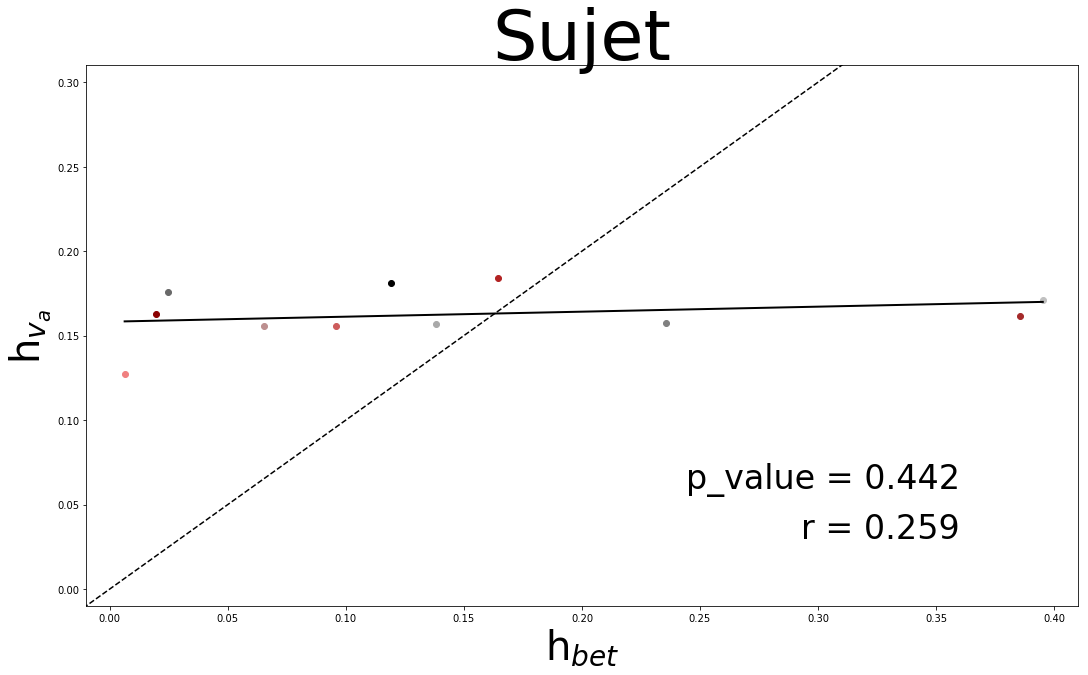

In [13]:
fig, axs = plt.subplots(1, 1, figsize=((fig_width), (fig_width)/(1.6180*1)), constrained_layout=True)

for x, color in enumerate(COLOR[:len(list_sujet)]):
    axs.scatter(h_bet_sujet[x], h_va_sujet[x],color=color)

#------------------------------------------------------------------------
axs.set_title('Sujet', fontsize=t_titre)
axs.set_xlabel('h$_{bet}$', fontsize=t_label)
axs.set_ylabel('h$_{v_a}$', fontsize=t_label)
axs.axis([-0.01 ,0.41,-0.01,0.31])


regress(axs, h_bet_sujet, h_va_sujet, 'k', minx=0, miny=0, maxx=0.4, maxy=0.3)
axs.plot(np.arange(-10,10), np.arange(-10,10), '--k')
plt.show()

In [14]:
def scatter_mean(bet, va, titre, maxx=0.55, maxy=0.25, ex=0.02, ey=0.01, ellipse=False) :
    
    if ellipse is True :
        from matplotlib.patches import Ellipse
    
    fig, axs = plt.subplots(1, 1, figsize=((fig_width), (fig_width)), constrained_layout=True) #/(1.6180*1))

    m_bet, m_va = [], []
    for x in range(len(bet)):
        if ellipse is True :
            ells = Ellipse((np.mean(bet[x]), np.mean(va[x])), 2*np.std(bet[x]), 2*np.std(va[x]), 0)
            ells.set_clip_box(axs.bbox)
            ells.set_alpha(0.2)
            ells.set_color('k')
            axs.add_artist(ells)
        
        #print(exp[x]['observer'], np.mean(bet[x]))
        axs.errorbar(np.mean(bet[x]), np.mean(va[x]),
                    xerr=np.std(bet[x]), yerr=np.std(va[x]),
                    color='k', fmt='o', elinewidth=2, ms=10, alpha=0.6)
        
        m_bet.append(np.mean(bet[x]))
        m_va.append(np.mean(va[x]))

    axs.set_title(titre, fontsize=t_titre)
    axs.set_xlabel('h$_{bet}$', fontsize=t_label)
    axs.set_ylabel('h$_{v_a}$', fontsize=t_label)
    axs.tick_params(axis='both', labelsize=t_label/1.8)
    
    axs.axis([-ex ,maxx+ex,-ey,maxy+ey])
    axs.plot(np.arange(-10,10), np.arange(-10,10), '--k')

    regress(axs, m_bet, m_va, 'r', minx=0, miny=0, maxx=maxx, maxy=maxy)
    
    fig.tight_layout()
    plt.show()
    return fig, axs

In [15]:
exts = ['.png', '.svg', '.pdf']

Moyenne par Sujet block


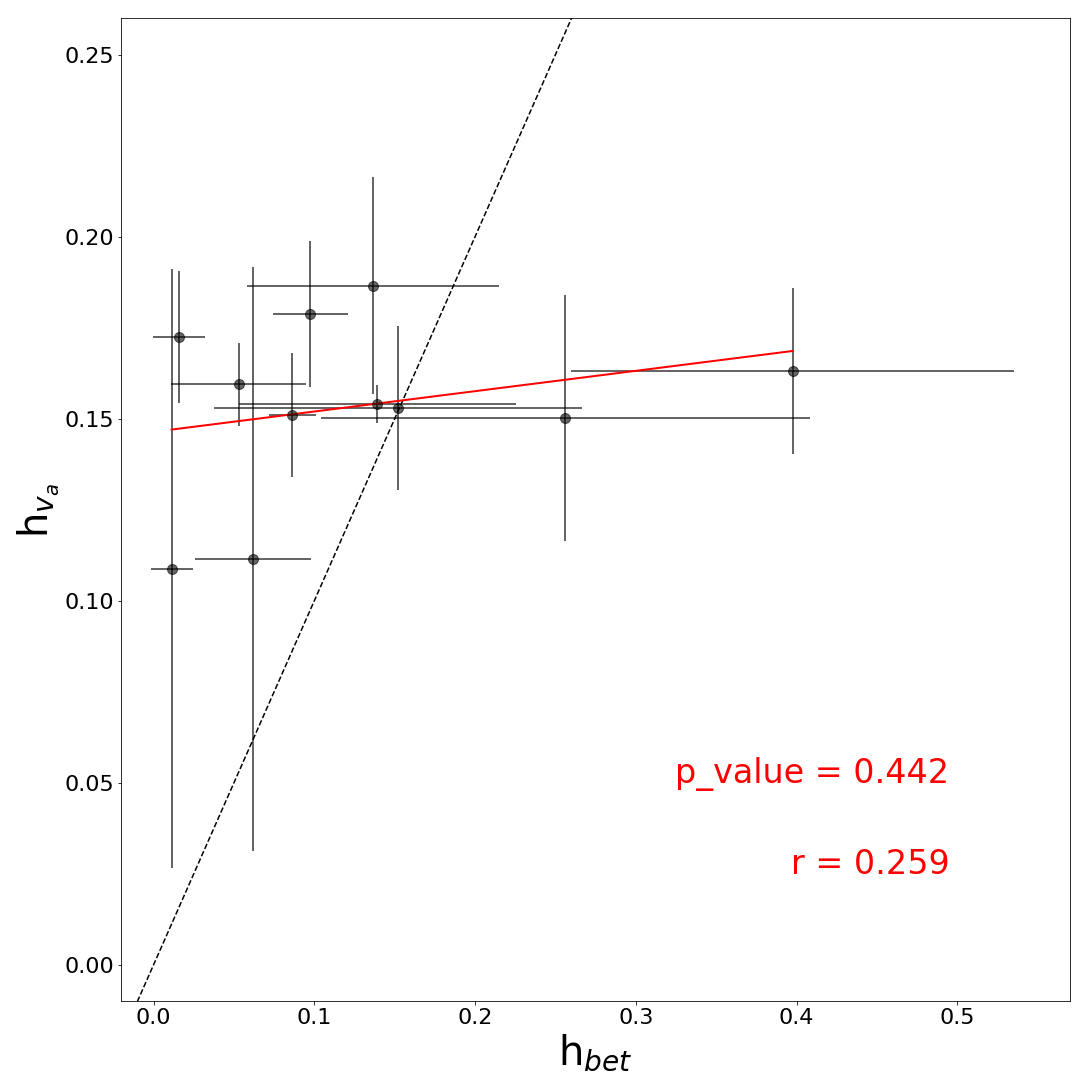

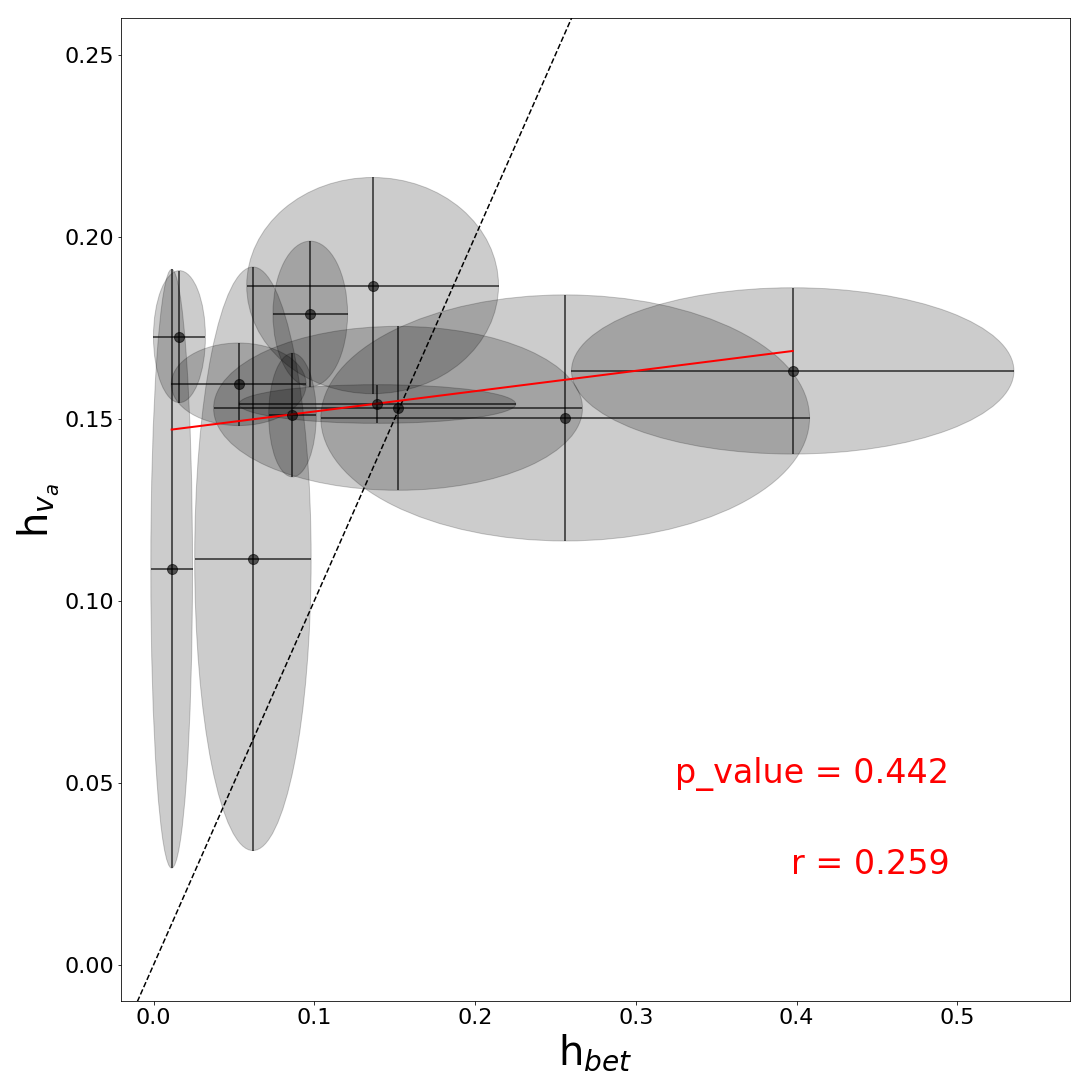

In [16]:
print('Moyenne par Sujet block')
fig, axs = scatter_mean(h_bet_block, h_va_block, '')
for ext in exts: fig.savefig('ms/figures/5_inter-individual_differences_fit' + ext, dpi=400)
fig1, axs1 = scatter_mean(h_bet_block, h_va_block, '', ellipse=True)

Moyenne par Sujet pause


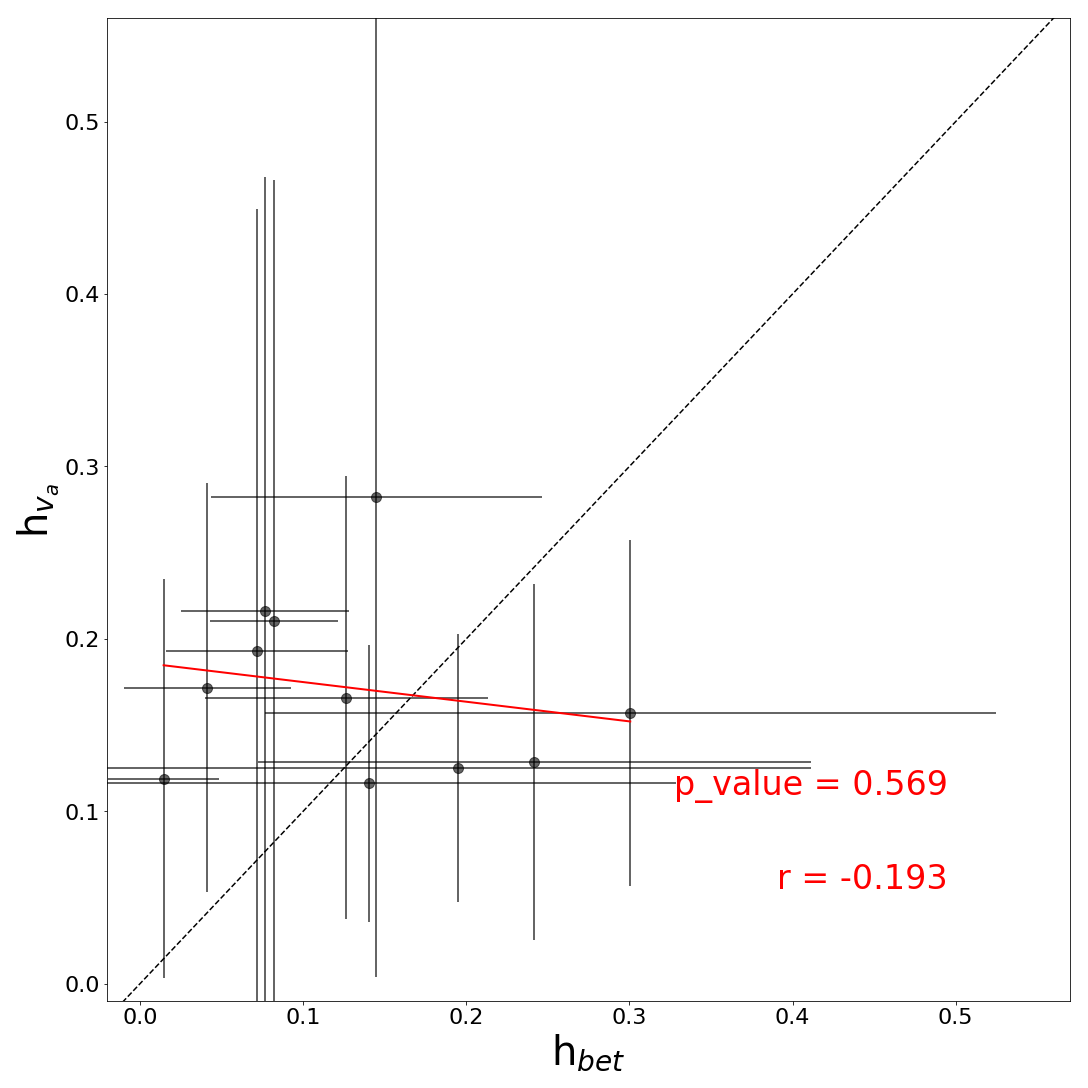

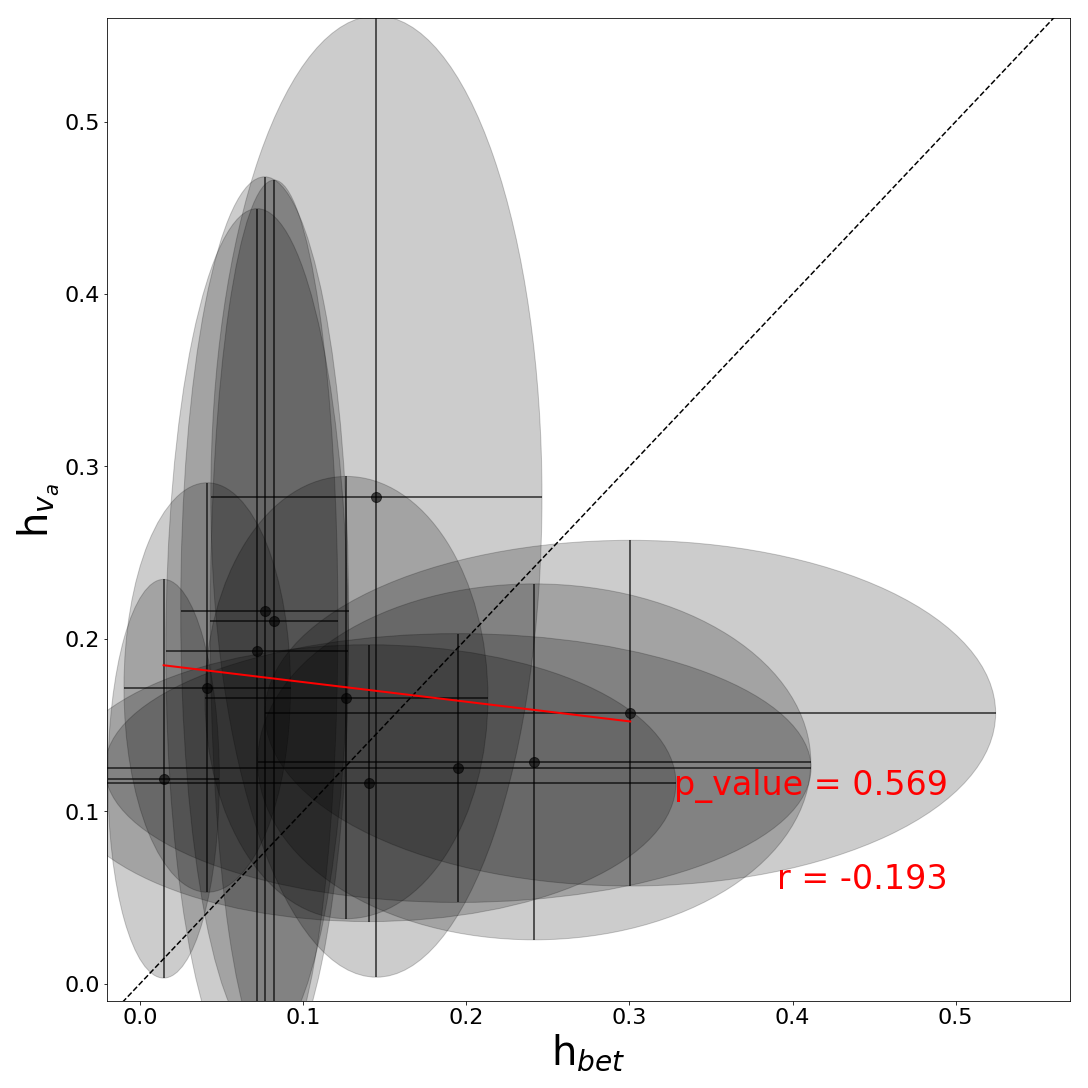

In [17]:
print('Moyenne par Sujet pause')
fig, axs = scatter_mean(h_bet_pause, h_va_pause, '',maxx=0.55, maxy=0.55)
fig1, axs1 = scatter_mean(h_bet_pause, h_va_pause, '',maxx=0.55, maxy=0.55, ellipse=True)

## MI

In [18]:
# https://matthew-brett.github.io/teaching/mutual_information.html
def mutual_information(hgram):
    """ Mutual information for joint histogram"""
    # Convert bins counts to probability values
    pxy = hgram / float(np.sum(hgram))
    px = np.sum(pxy, axis=1) # marginal for x over y
    py = np.sum(pxy, axis=0) # marginal for y over x
    px_py = px[:, None] * py[None, :] # Broadcast to multiply marginals
    # Now we can do the calculation using the pxy, px_py 2D arrays
    nzs = pxy > 0 # Only non-zero pxy values contribute to the sum
    return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

In [19]:
fig_width = 15
t_titre = 70
t_label = 30*4

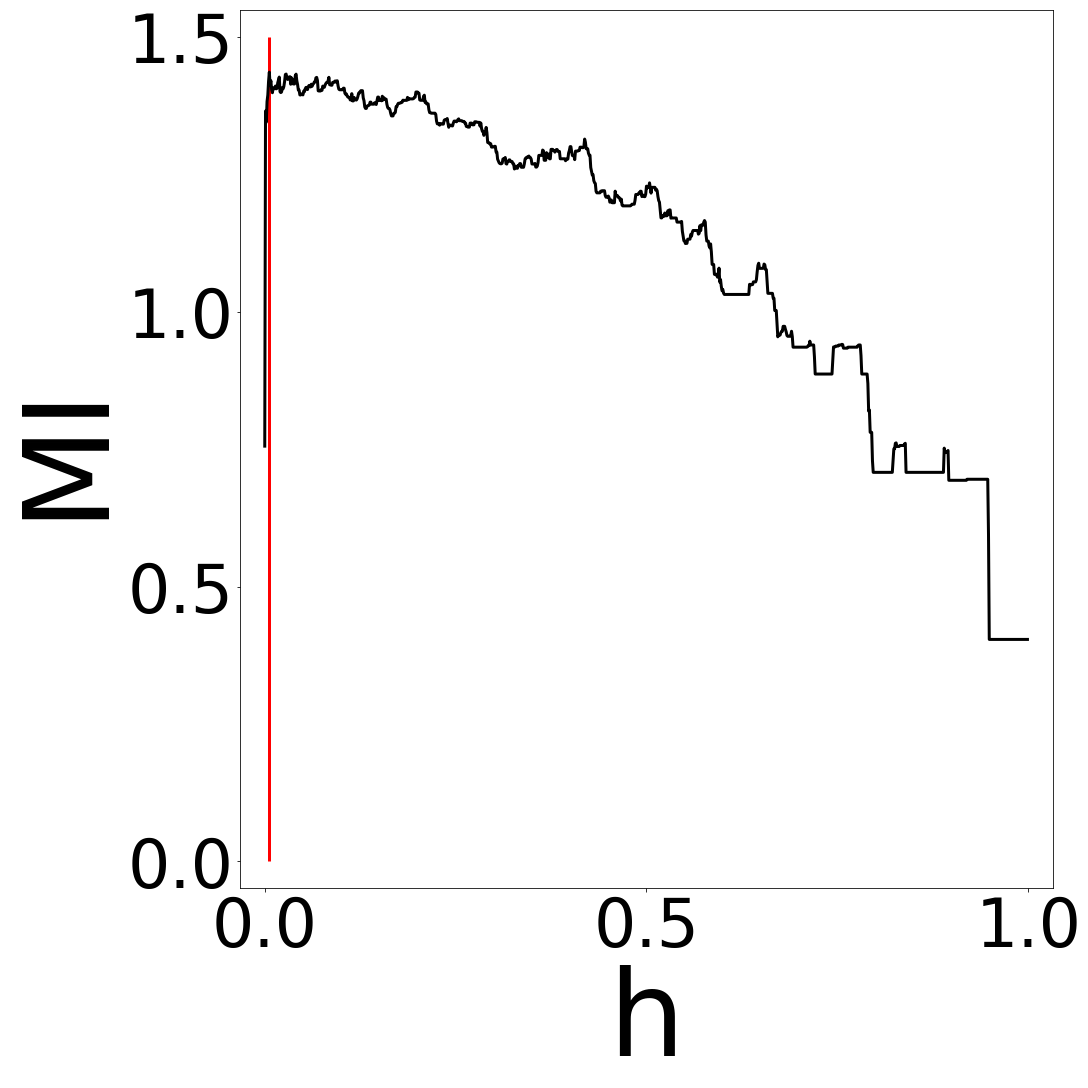

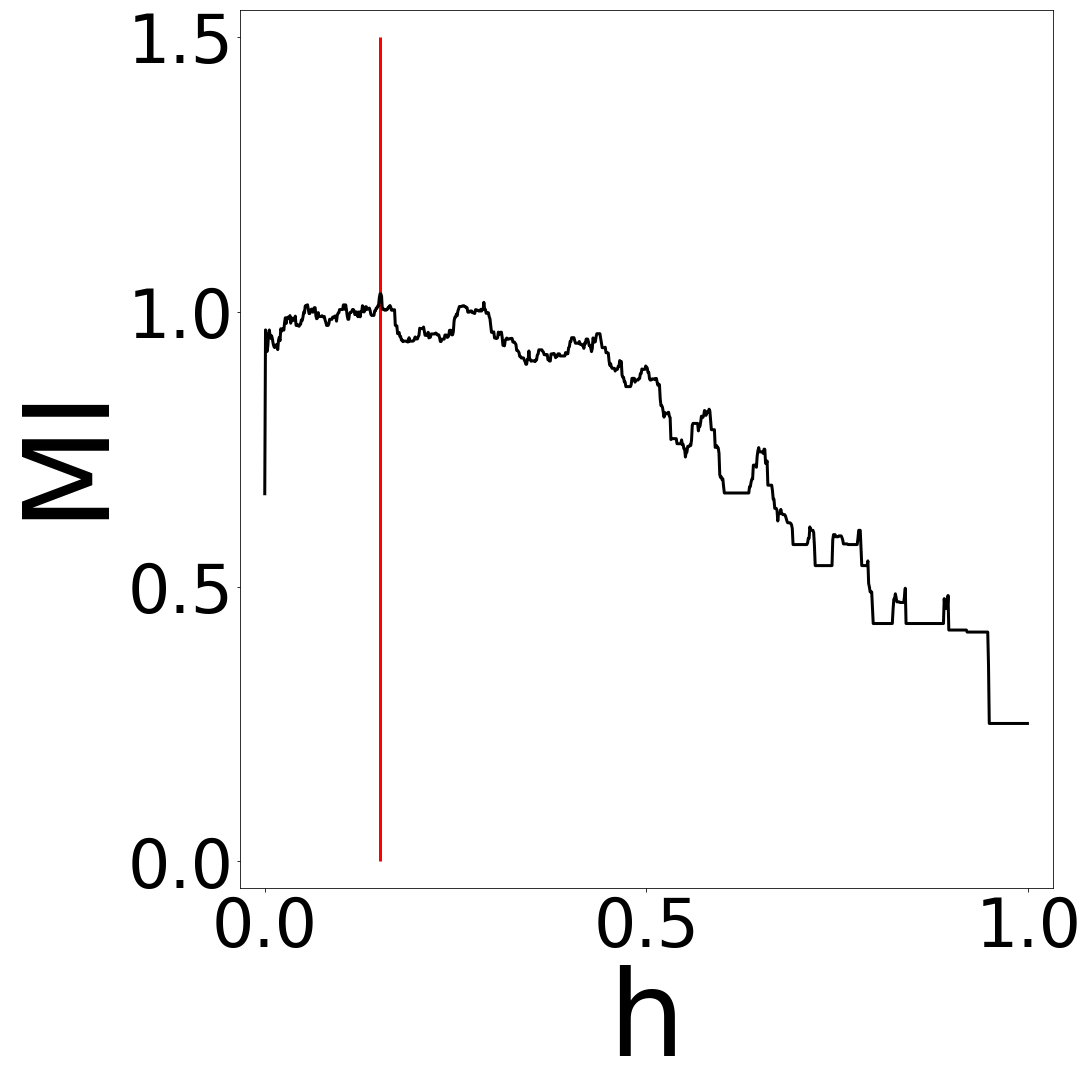

In [20]:
mi_h_bet_block, mi_h_va_block = [], []
mimi_bet_block, mimi_va_block = [], []

for x in range(len(exp)) :
    
    prob_sujet, bet_sujet, v_anti_sujet = [], [], []
    
    p = exp[x]['p']
    tau = exp[x]['N_trials']/5.
    h = 1./tau 
    hs = np.arange(0,1,0.001) #h*np.logspace(-1., 1., 50)
    
    bet = (exp[x]['results']+1)/2 # results est sur [-1,1] on le ramene sur [0,1]
    a_anti = param[x]['v_anti']
    latence = param[x]['latence']
    start_anti = param[x]['start_anti']
    
    
    mi_h_bet_block.append([])
    mi_h_va_block.append([])
    
    mimi_bet_block.append([])
    mimi_va_block.append([])

    for block in range(exp[x]['N_blocks']):
        va = (np.array(a_anti[block])*((np.array(latence[block])-np.array(start_anti[block]))/1000))
        prob_block = p[:, block, 0]
        
        mi_bet = np.ndarray(len(hs))
        mi_va = np.ndarray(len(hs))

        for H in range(len(hs)):
            p_hat = fct_BCP(prob_block, hs[H])
            p_hat_nan = np.ma.masked_array(p_hat, mask=np.isnan(va)).compressed()
            va_nan = np.ma.masked_array(va, mask=np.isnan(va)).compressed()
            
            hist_bet, x_edges, y_edges = np.histogram2d(p_hat,bet[:, block],bins=20)
            hist_va, x_edges, y_edges = np.histogram2d(p_hat_nan,va_nan,bins=20)

            mi_bet[H] = mutual_information(hist_bet)
            mi_va[H] = mutual_information(hist_va)
        
        
                            
        tutu_bet = mi_bet.argmax()
        tutu_va = mi_va.argmax()
        
        if x==5 :
            if block==1:
                fig, axs = plt.subplots(1, 1, figsize=((fig_width), (fig_width)), constrained_layout=True)#/(1.6180*1)))
                axs.vlines(hs[tutu_bet], 0, 1.5, colors='r', lw=3) 
                axs.plot(hs, mi_bet, c='k', lw=3)
                axs.axis([-0.032 , 1.032,-0.048,1.548])
                axs.set_xlabel('h', fontsize=t_label)
                axs.set_ylabel('MI', fontsize=t_label)
                axs.tick_params(axis='both', labelsize=t_label/1.8)
                for ext in exts: fig.savefig('ms/figures/5_A_h_bet' + ext, dpi=400)
                
                fig, axs = plt.subplots(1, 1, figsize=((fig_width), (fig_width)), constrained_layout=True)#/(1.6180*1)))
                axs.vlines(hs[tutu_va], 0, 1.5, colors='r', lw=3) 
                axs.plot(hs, mi_va, c='k', lw=3)
                axs.axis([-0.032 , 1.032,-0.048,1.548])
                axs.set_xlabel('h', fontsize=t_label)
                axs.set_ylabel('MI', fontsize=t_label)
                axs.tick_params(axis='both', labelsize=t_label/1.8)
                for ext in exts: fig.savefig('ms/figures/5_A_h_va' + ext, dpi=400)
                
        
        mi_h_bet_block[x].append(hs[tutu_bet])
        mi_h_va_block[x].append(hs[tutu_va])


        mimi_bet_block[x].append(mi_bet[tutu_bet])
        mimi_va_block[x].append(mi_va[tutu_va])

Moyenne par Sujet block


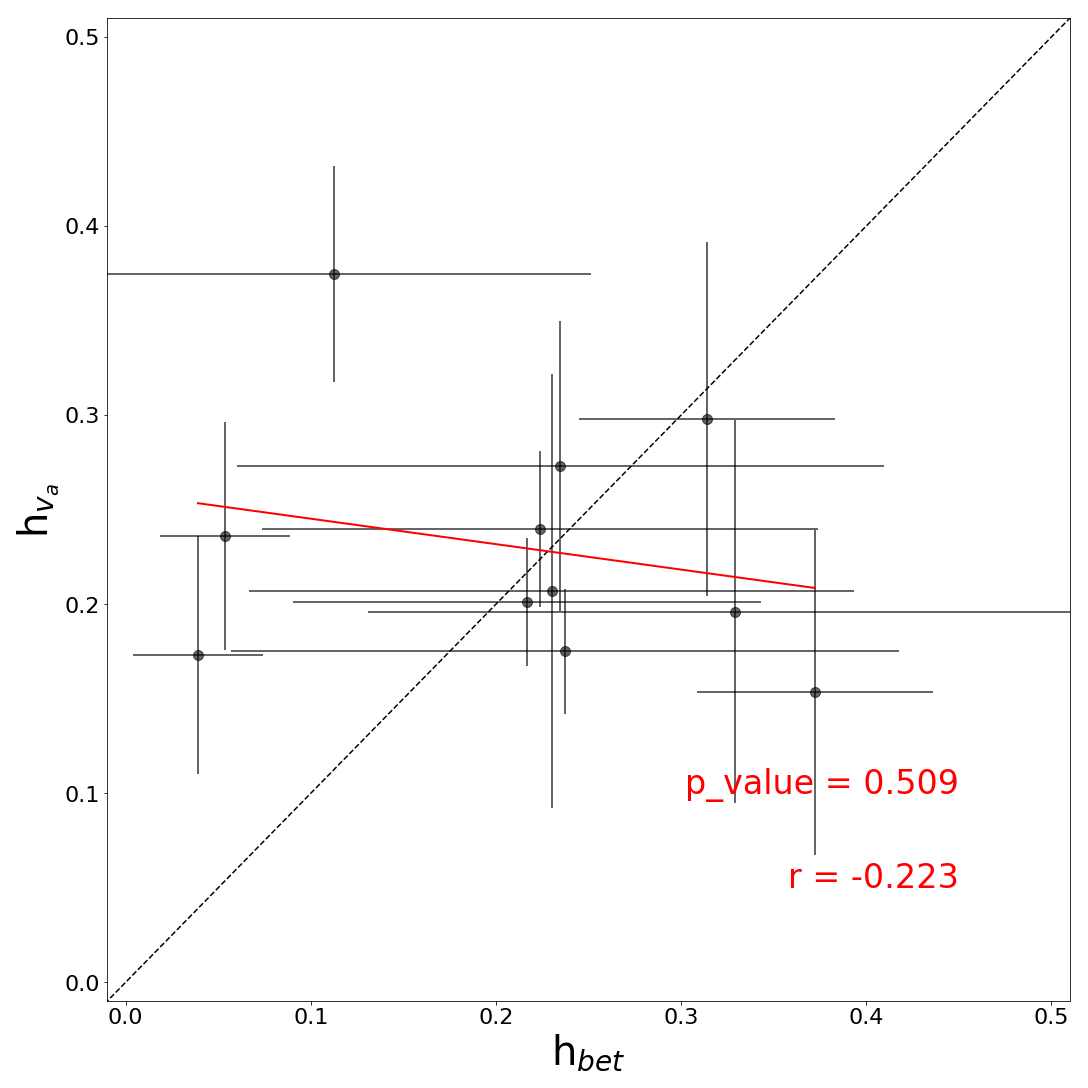

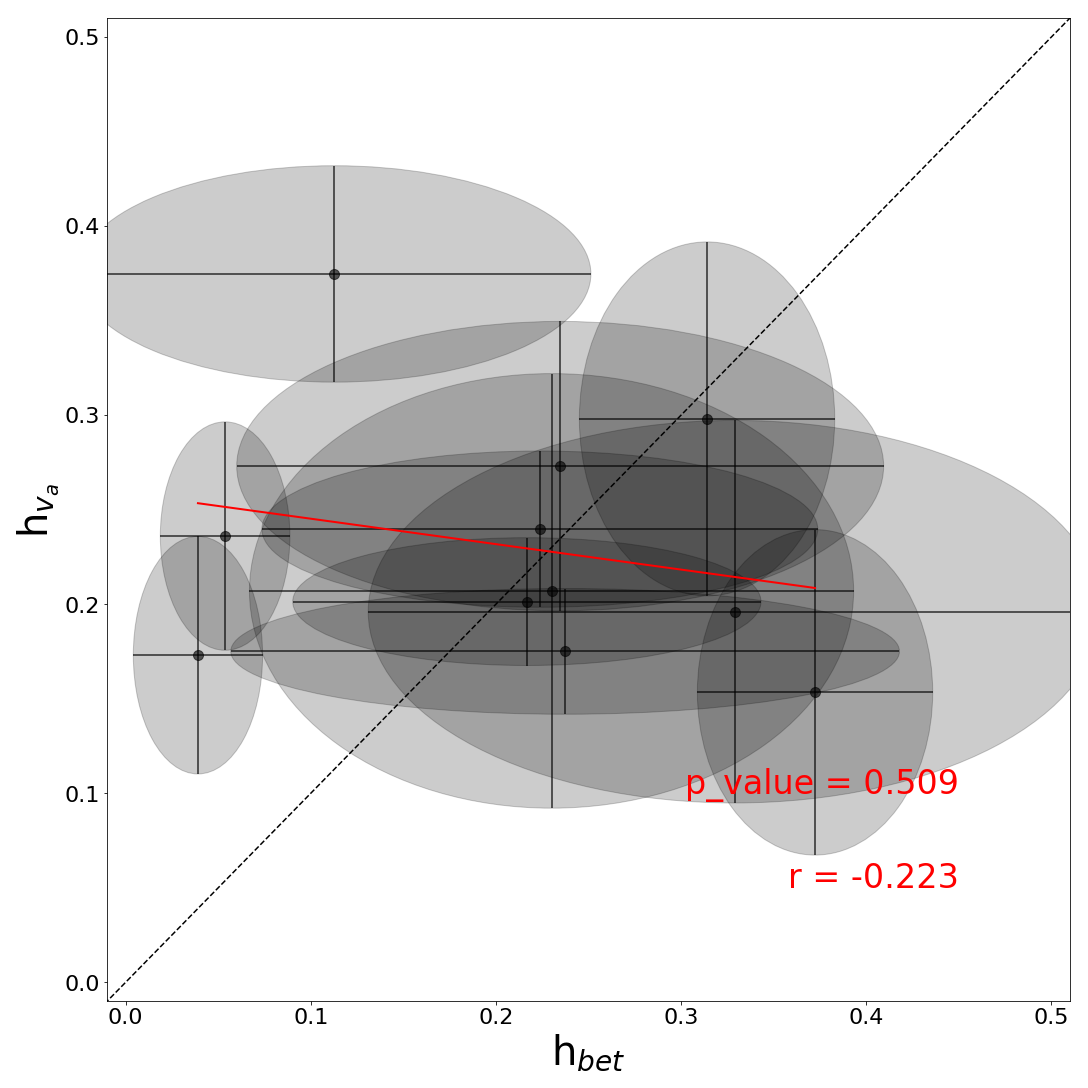

In [21]:
print('Moyenne par Sujet block')
fig_width = 15
t_titre = 70
t_label = (30*4)/3
fig, axs = scatter_mean(mi_h_bet_block, mi_h_va_block, '', maxx=0.5, maxy=0.5, ex=0.01, ey=0.01)
fig.tight_layout()
for ext in exts: fig.savefig('ms/figures/5_inter-individual_differences_MI' + ext, dpi=400)
    
fig1, axs1 = scatter_mean(mi_h_bet_block, mi_h_va_block, '', maxx=0.5, maxy=0.5, ex=0.01, ey=0.01, ellipse=True)
fig1.tight_layout()

In [22]:
print(exp[5]['observer'])

IP
